In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [13]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [14]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [15]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [16]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

# Opt 

In [17]:
volume = Volume(get_layers())
dets = volume.get_detectors()
opt = torch.optim.SGD(volume.parameters(), lr=2e-3)
mu = MuonBatch(generate_batch(1000), init_z=1)
volume(mu)
scatters = ScatterBatch(mu, volume)

In [69]:
from torch.distributions import Normal

In [145]:
loc_unc = 0.1*torch.ones(2,3)

In [151]:
dists = {}
for i, d in enumerate(['x','y','z']):
    dists[d] = Normal(0.5+torch.zeros(2), loc_unc[:,i])

In [162]:
lower = Tensor(np.mgrid[0:1:0.1, 0:1:0.1, 0.2:0.8:0.1].reshape(3,-1).T)
lower

tensor([[0.0000, 0.0000, 0.2000],
        [0.0000, 0.0000, 0.3000],
        [0.0000, 0.0000, 0.4000],
        ...,
        [0.9000, 0.9000, 0.6000],
        [0.9000, 0.9000, 0.7000],
        [0.9000, 0.9000, 0.8000]])

In [167]:
def comp_int(low, high):
    return torch.prod(torch.stack([dists[d].cdf(high[i])-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)

In [168]:
prob = torch.stack([comp_int(l, l+0.1) for l in lower.unbind()])

In [172]:
prob = prob.T.reshape(2,10,10,7)

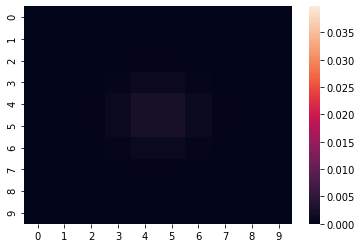

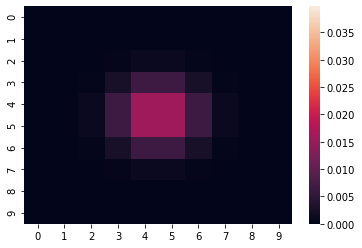

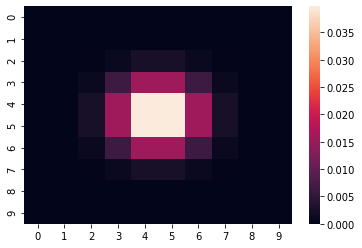

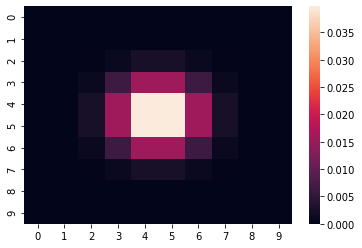

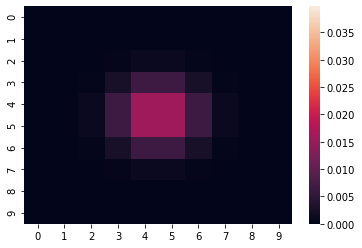

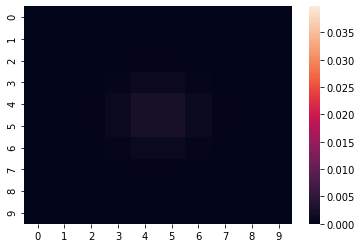

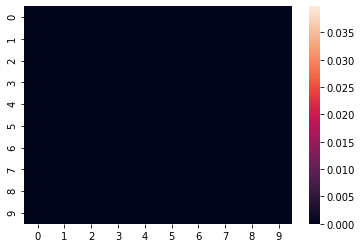

In [176]:
for l in range(7):
    sns.heatmap(prob[0,:,:,l], vmax=prob.max(), vmin=prob.min())
    plt.show()

In [135]:
from torch._vmap_internals import _vmap as vmap

In [127]:
vmap(comp_int)(lower, lower+0.1)

RuntimeError: Batching rule not implemented for aten::is_nonzero. We could not generate a fallback.

In [283]:
class GaussianX0Inferer(X0Inferer):
    def average_preds(
        self, x0_dtheta: Optional[Tensor], x0_dtheta_unc: Optional[Tensor], x0_dxy: Optional[Tensor], x0_dxy_unc: Optional[Tensor], efficiency: Tensor
    ) -> Tuple[Tensor, Tensor]:
        r"""
        TODO: Implement differing x0 accorind to location via Gaussian spread
        TODO: Don't assume that location uncertainties are uncorrelated
        """

        loc, loc_unc = self.scatters.location[self.mask], self.scatters.location_unc[self.mask]
        shp = len(loc), len(self.volume.get_passives()), *(self.volume.lw / self.volume.size).long()

        wpreds, weights = [], []
        for x0, unc in ((x0_dtheta, x0_dtheta_unc), (x0_dxy, x0_dxy_unc)):
            if x0 is None or unc is None:
                continue
            x0 = x0[:,None,None,None].expand(shp).clone()
            coef = efficiency[:,None,None,None].expand(shp).clone() / ((1e-17) + (unc[:,None,None,None].expand(shp).clone() ** 2))
            
            # Gaussian spread
            dists = {}
            for i, d in enumerate(['x','y','z']):
                dists[d] = Normal(loc[:,i], loc_unc[:,i])
            lower = Tensor((self.volume.size*np.mgrid[round(self.volume.get_passive_z_range()[0].numpy()[0]/self.volume.size):round(self.volume.get_passive_z_range()[1].numpy()[0]/self.volume.size):1,
                                                      0:round(self.volume.lw.numpy()[0]/self.volume.size):1,
                                                      0:round(self.volume.lw.numpy()[1]/self.volume.size):1]).reshape(3,-1).T)
            
            def comp_int(low:Tensor, high:Tensor, dists:Dict[str, Tensor]) -> Tensor:
                return torch.prod(torch.stack([dists[d].cdf(high[i])-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)
            
            prob = torch.stack([comp_int(l, l+self.volume.size, dists) for l in lower.unbind()]).T.reshape(shp)  # TODO: vmap this
            coef = coef*prob
            
            wpreds.append(x0)
            weights.append(coef)

        wpred, weight = torch.cat(wpreds, dim=0), torch.cat(weights, dim=0)
        wpred, weight = wpred.sum(0), weight.sum(0)
        pred = wpred / weight

        return pred, weight

In [284]:
x0_gaussian_inferer = GaussianX0Inferer(scatters=scatters)

In [285]:
x0_inferer = X0Inferer(scatters=scatters)

In [290]:
pred_g, weight_g = x0_gaussian_inferer.pred_x0(False)

In [295]:
pred, weight = x0_inferer.pred_x0(False)

In [291]:
pred_g.shape

torch.Size([6, 10, 10])

In [293]:
weight_g.shape

torch.Size([6, 10, 10])

In [298]:
pred_g[pred == pred].mean()

tensor(0.0003, grad_fn=<MeanBackward0>)

In [299]:
pred[pred == pred].mean()

tensor(0.0030, grad_fn=<MeanBackward0>)